In [2]:
import os
from pathlib import Path
from data_loader import load_prices, load_storage, load_efficiency, load_plant_capacity, load_demand
import pandas as pd

current_dir = Path().resolve()
data_folder = os.path.join(current_dir.parent, "data")
start_date = "2020-01"
end_date = "2022-12"
resample_method = 'M' # Monthly resampling
zone = 'DK_1'

output_path = os.path.join(current_dir.parent, "results", "figures")
os.makedirs(output_path, exist_ok=True)


fuel_prices_file = os.path.join(data_folder, "fuel_prices.csv") 
efficiency_file = os.path.join(data_folder, "efficiency.csv") 
demand_file = os.path.join(data_folder, "electricity_demand.csv")

fuel_prices_df = load_prices(fuel_prices_file, start_date, end_date, resample_method= resample_method)
period_index = fuel_prices_df.index 
efficiencies = load_efficiency(efficiency_file)
demand_df = load_demand(demand_file, start_date, end_date, resample_method= resample_method, zone=zone, supply_factor=0.6)






/Users/lalka/Projects/46750_g28_Assignment_2/src/data_loader.py:81: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(resample_method).mean()
/Users/lalka/Projects/46750_g28_Assignment_2/src/data_loader.py:193: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df[selected_col].resample(resample_method).sum()


In [3]:
# 1) Scenario definitions
scenario_list = ["low", "standard", "high"]

# 2) Multiplicative factors per fuel and scenario
#    - Gas is most volatile, coal least volatile
#    - Factors are multiplicative: scaled_price = base_price * factor
price_factors = {
    "coal":    {"low": 0.97, "standard": 1.00, "high": 1.03},   # +/- ~3%
    "oil":     {"low": 0.92, "standard": 1.00, "high": 1.08},   # ~8% swing
    "gas":     {"low": 0.80, "standard": 1.00, "high": 1.25},   # large volatility
}

# If you have extra fuels (e.g. 'lignite') present in fuel_prices_df, we preserve them (standard=1.0)
for col in fuel_prices_df.columns:
    if col not in price_factors:
        price_factors[col] = {s: 1.0 for s in scenario_list}

# 3) Seasonal probabilities 
#    Rationale: fuels (especially gas) tend to show seasonal patterns (higher risk of high prices in winter).
#    Seasonal buckets: winter=Dec/Jan/Feb, spring=Mar/Apr/May, summer=Jun/Jul/Aug, autumn=Sep/Oct/Nov
seasonal_scenario_probs = {
    "winter": {"low": 0.10, "standard": 0.40, "high": 0.50},
    "spring": {"low": 0.25, "standard": 0.60, "high": 0.15},
    "summer": {"low": 0.40, "standard": 0.50, "high": 0.10},
    "autumn": {"low": 0.20, "standard": 0.60, "high": 0.20},
}

def month_to_season(month: int) -> str:
    if month in (12, 1, 2):
        return "winter"
    if month in (3, 4, 5):
        return "spring"
    if month in (6, 7, 8):
        return "summer"
    return "autumn"

# 4) Build scenario_prices (dict of DataFrames) and scenario probability DataFrame (indexed by original index)
scenario_prices = {s: fuel_prices_df.copy(deep=True) for s in scenario_list}

# Ensure index is datetime (should be already from your loader) and use it to create probabilities by period
index = fuel_prices_df.index
if not isinstance(index, pd.DatetimeIndex):
    # fallback: if index was integer-range, try to use a 'month' column if present
    if "month" in fuel_prices_df.columns:
        index = pd.to_datetime(fuel_prices_df["month"])
        for df in scenario_prices.values():
            df.index = index
    else:
        raise RuntimeError("fuel_prices_df must have a DatetimeIndex or a 'month' column parseable to dates.")

# Create a DataFrame of probabilities for each period
scenario_prob_df = pd.DataFrame(index=index, columns=scenario_list, dtype=float)

for ts in index:
    season = month_to_season(ts.month)
    probs = seasonal_scenario_probs[season]
    # assign same probabilities for all fuels in that month (you could vary by fuel if desired)
    scenario_prob_df.loc[ts, list(probs.keys())] = [probs[k] for k in scenario_list]

# 5) Create scaled price DataFrames
for scenario in scenario_list:
    df_scaled = fuel_prices_df.copy(deep=True)
    # apply fuel-specific factor for each column
    for fuel in df_scaled.columns:
        factor = price_factors.get(fuel, {}).get(scenario, 1.0)
        # multiply only numeric values
        df_scaled[fuel] = pd.to_numeric(df_scaled[fuel], errors="coerce") * factor
    scenario_prices[scenario] = df_scaled

# 6) Create objects used in stochastic model
scenario_index_to_t = {i: scenario for i, scenario in enumerate(scenario_list)}  # e.g. 0->"low"
# scenario probabilities per time-step as numpy array shaped (T, n_scenarios)
prob_array = scenario_prob_df[scenario_list].to_numpy(dtype=float)

expected_df = sum(
    scenario_prices[sc].multiply(scenario_prob_df[sc], axis=0)
    for sc in scenario_prob_df.columns
)


# - scenario_prices: dict {scenario_name: DataFrame_of_scaled_prices}
# - scenario_prob_df: DataFrame indexed by time with columns ['low','standard','high'] giving probabilities
# - prob_array: numpy array (T x 3) with probabilities for building the stochastic model
# - scenario_list and scenario_index_to_t helpers



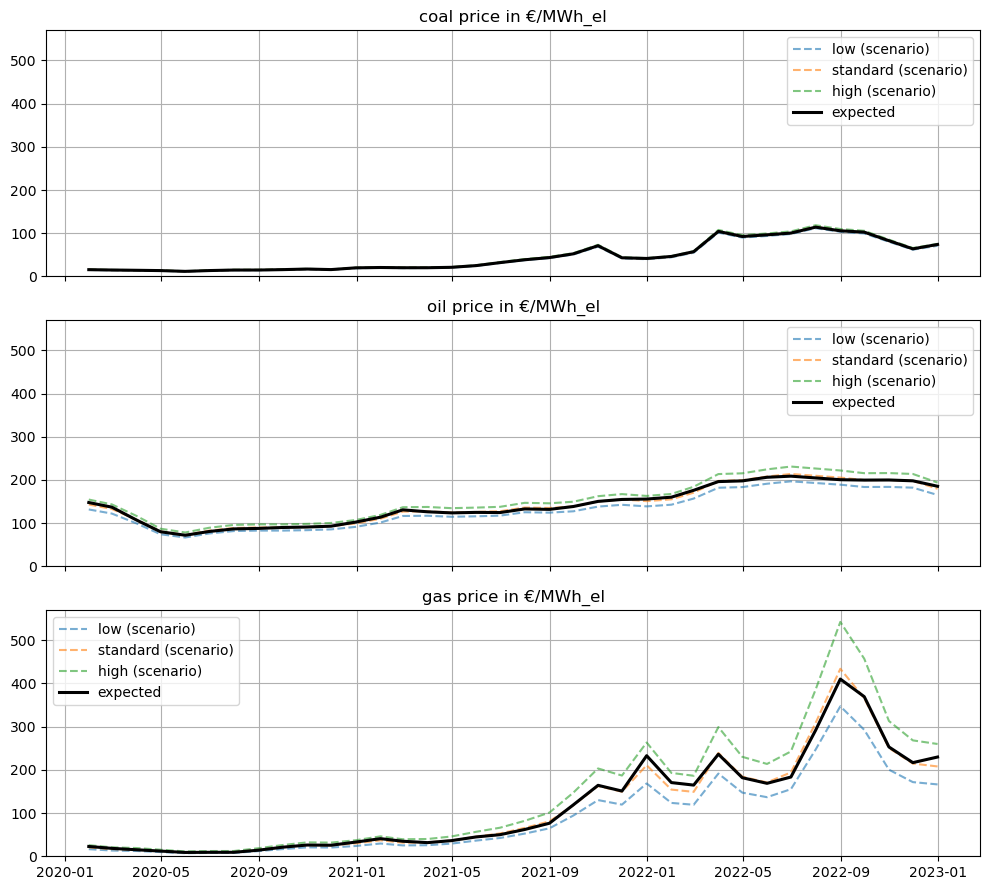

Saved fuel price scenarios and expected plot to: /Users/lalka/Projects/46750_g28_Assignment_2/results/figures/fuel_price_scenarios_expected.png


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1) Build expected_prices if you don't already have it
expected_prices = sum(
    scenario_prices[s].multiply(scenario_prob_df[s], axis=0)
    for s in scenario_prob_df.columns
)

# sanity: expected_prices index should match period_index
expected_prices = expected_prices.reindex(index=period_index)

# --- 2) Convert to electricity prices (€/MWh_el) using efficiencies
expected_prices_MWhel = expected_prices.copy()
for f in efficiencies:
    if f in expected_prices_MWhel.columns:
        expected_prices_MWhel[f] = expected_prices_MWhel[f] / efficiencies[f]

scenario_prices_MWhel = {}
for s in scenario_list:
    scenario_prices_MWhel[s] = scenario_prices[s].copy()
    for f in efficiencies:
        if f in scenario_prices_MWhel[s].columns:
            scenario_prices_MWhel[s][f] = scenario_prices_MWhel[s][f] / efficiencies[f]


# --- 3) Determine global y-axis limits
all_prices = []
for f in efficiencies:
    all_prices.append(expected_prices_MWhel[f])
    for s in scenario_list:
        all_prices.append(scenario_prices_MWhel[s][f])
y_min = min(pd.concat(all_prices).min(), 0)  # include 0 for better visual
y_max = pd.concat(all_prices).max() * 1.05   # add 5% margin

# --- 4) Simple plot: scenarios + expected for each fuel
fuels = ['coal','oil','gas']   # adapt if you have different names or extra fuels
n = len(fuels)
fig, axs = plt.subplots(n, 1, figsize=(10, 3*n), sharex=True)
if n == 1:
    axs = [axs]

for ax, f in zip(axs, fuels):
    # plot each scenario
    for s in scenario_list:
        if f in scenario_prices_MWhel[s].columns:
            ax.plot(scenario_prices_MWhel[s].index, scenario_prices_MWhel[s][f],
                    linestyle='--', alpha=0.6, label=f"{s} (scenario)")
    # plot expected
    ax.plot(expected_prices_MWhel.index, expected_prices_MWhel[f],
            linewidth=2.2, label="expected", color='black')
    ax.set_title(f"{f} price in €/MWh_el")
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

# Save plot 
plot_path = os.path.join(output_path, "fuel_price_scenarios_expected.png")
fig.savefig(plot_path)
print(f"Saved fuel price scenarios and expected plot to: {plot_path}")


Total Cost from Model 1: EUR 3491018107.33
Total Cost from Model 2: EUR 2825611134.40
Total Cost from Model 3: EUR 2548139022.91


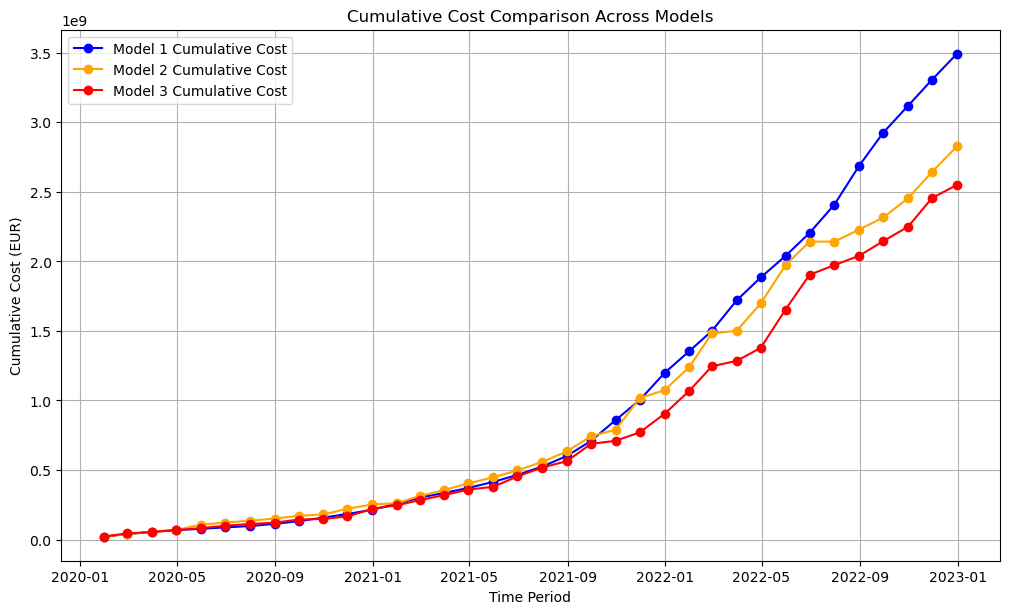

Saved cumulative cost comparison plot to: /Users/lalka/Projects/46750_g28_Assignment_2/results/figures/cumulative_cost_comparison_model1_2_3.png


In [5]:
model1_results_file = os.path.join(current_dir.parent, "results", "model1", "model1_results.csv")
model1_results_df = pd.read_csv(model1_results_file)
model1_total_cost = model1_results_df['Accumulated_Cost'].iloc[-1]
print(f"Total Cost from Model 1: EUR {model1_total_cost:.2f}")


model2_results_file = os.path.join(current_dir.parent, "results", "model2", "model2_results.csv")
model2_results_df = pd.read_csv(model2_results_file)
model2_total_cost = model2_results_df['Accumulated_Cost'].iloc[-1]

print(f"Total Cost from Model 2: EUR {model2_total_cost:.2f}")


model3_results_file = os.path.join(current_dir.parent, "results", "model3", "stochastic_expected_running_cost.csv")
model3_results_df = pd.read_csv(model3_results_file)
model3_total_cost = model3_results_df['Accumulated_Cost'].iloc[-1]

print(f"Total Cost from Model 3: EUR {model3_total_cost:.2f}")



plt.figure(figsize=(10, 6))
plt.plot(demand_df.index, model1_results_df['Accumulated_Cost'], marker='o', label='Model 1 Cumulative Cost', color='blue')
plt.plot(demand_df.index, model2_results_df['Accumulated_Cost'], marker='o', label='Model 2 Cumulative Cost', color='orange')
plt.plot(demand_df.index, model3_results_df['Accumulated_Cost'], marker='o', label='Model 3 Cumulative Cost', color='red')



plt.legend()
plt.tight_layout()
plt.title('Cumulative Cost Comparison Across Models')
plt.grid()
plt.xlabel('Time Period')
plt.ylabel('Cumulative Cost (EUR)')

# Save as comparison plot
comparison_plot_path = os.path.join(output_path, "cumulative_cost_comparison_model1_2_3.png")
plt.savefig(comparison_plot_path)
plt.show()
print(f"Saved cumulative cost comparison plot to: {comparison_plot_path}")


Saved cumulative cost comparison overview plot to: /Users/lalka/Projects/46750_g28_Assignment_2/results/figures/cumulative_cost_comparison_overview.png


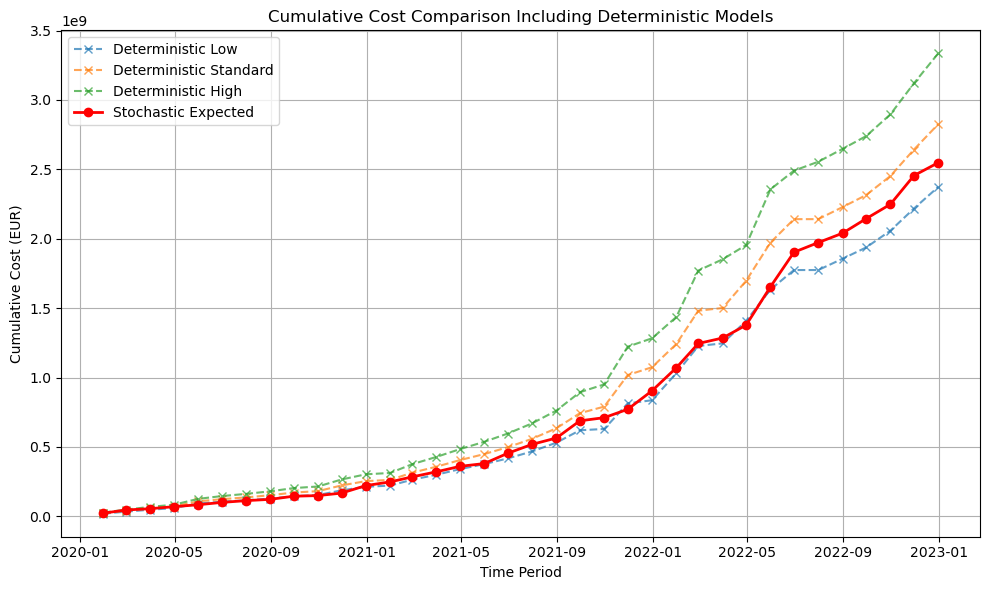

In [6]:
# Plot overview including the deterministic models (low, standard, high)
plt.figure(figsize=(10, 6))

# Get results folder for model 3
results_model3_dir = os.path.join(current_dir.parent, "results", "model3")
# Read in the deterministic results
for sname in scenario_list:
    det_file = os.path.join(results_model3_dir, f"deterministic_running_costs_{sname}.csv")
    det_df = pd.read_csv(det_file)
    plt.plot(demand_df.index, det_df['Accumulated_Cost'], marker='x', linestyle='--', label=f'Deterministic {sname.capitalize()}', alpha=0.7)

# Add the stochastic expected cost line
plt.plot(demand_df.index, model3_results_df['Accumulated_Cost'], marker='o', label='Stochastic Expected', color='red', linewidth=2)   
plt.legend()
plt.title('Cumulative Cost Comparison Including Deterministic Models')
plt.grid()
plt.xlabel('Time Period')
plt.ylabel('Cumulative Cost (EUR)')
plt.tight_layout()
overview_plot_path = os.path.join(output_path, "cumulative_cost_comparison_overview.png")
plt.savefig(overview_plot_path)
print(f"Saved cumulative cost comparison overview plot to: {overview_plot_path}")
plt.show()